# [E-10]뉴스 요약봇 만들기

## 0. 텍스트 요약(Text Summarization)이란?
텍스트 요약 : 긴 길이의 문서원문을 핵심 주제만으로 구성된 짧은 요약 문장들로 변환하는 것
  
- 추출적 요약(Extractive Summarization)  
: 원문에서 문장들을 추출해서 요약하는 방식
- 추상적 요약(Abstractive Summarization)  
: 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 방식


## 1. 데이터 준비하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

## 2. 데이터 전처리하기

### 2.1 데이터 분석

In [63]:
print('전체 데이터 수 :', (len(data)))

전체 데이터 수 : 98401


In [64]:
data.sample(10)

,headlines,text
9334,Maha drivers will lose licence for breaking tr...,In a move to combat the rise in road accidents...
12963,On-court coaching should be allowed: Serena Wi...,American tennis player Serena Williams' coach ...
60339,Yuva Sena chief proposes using plastic waste t...,Yuva Sena chief Aaditya Thackeray has asked th...
61137,"No VIP treatment to Ram Rahim, inmates can't s...",Haryana MLA Krishan Lal Panwar dismissed repor...
10555,Trump signs order denying asylum to illegal mi...,US President Donald Trump on Friday signed an ...
85410,Competition is on: Katrina on dance video with...,Actress Katrina Kaif on Instagram shared a vid...
56338,US woman arrested for sending Bitcoin to aid I...,A woman in US' Long Island was arrested for al...
78348,Film on 1975 Emergency 'Indu Sarkar' hits the ...,"'Indu Sarkar', which is based on 1975 Emergenc..."
73478,Amole Gupte directorial 'Sniff' hits the theatres,"Amole Gupte directorial 'Sniff', which release..."
46765,Man posts woman's fake nude pics on social med...,A 26-year-old woman from Mumbai has filed an F...


데이터는 총 98401개가 있고 `text`와 `headlines` 두가지 열로 구성되어져 있다.  
`text`는 본문, `headlines`는 요약된 데이터이다. 이 두개로 추상적 요약을 할 수 있고, 추출적 요약을 하는 경우에는  `text`열만 사용해야한다.

### 2.2 데이터 정제

#### 2.2.1 중복 데이터 제거

In [65]:
print('Text 열에서 중복을 배제한 유일한 데이터의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 데이터의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 데이터의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 데이터의 수 : 98280


Text가 다르더라도 Headlines가 같을 수 있기 때문에 Headlines가 중복된 경우는 남겨두고 Text가 중복된 경우에만 제거를 해준다.

In [66]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 데이터수 :', (len(data)))

전체 데이터수 : 98360


#### 2.2.2 NULL 값이 존재하는 데이터 제거

In [67]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


다행이 NULL값인 데이터는 없다. 만약 있을 경우 `dropna()` 함수를 사용하면 쉽게 제거할 수 있다

### 2.3 정규화와 불용어제거

#### 2.3.1 텍스트 정규화(text normalization)

In [68]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 2.3.2 불용어

In [69]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### 2.3.3 데이터 전처리 함수

In [70]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
        
    return tokens

In [71]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


#### 2.3.4 멀티 프로세싱

싱글 프로세스로 실행하면 데이터 전처리하는데 꽤나 많은 시간이 소요된다.  
멀티 프로세싱을 활용하여 별도의 프로세스를 생성한후 병렬처리하면 CPU수에 비례하여 획기적으로 소요 시간을 줄일 수 있다.  
colab은 cpu 코어 수가 2라서 소요 시간이 많이 줄어 들지는 않는 것 같다..  
그에비해 클라우드는 6개를 가지고 있어서 빠르게 되는 것을 확인할 수 있었다. (225.78298091888428,5.290556192398071)

In [72]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다
  print(num_cores)

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

6
188.44237303733826  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter z

In [73]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [74]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2.4 데이터 셋 분리

#### 2.4.1 데이터 최대 길이 설정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


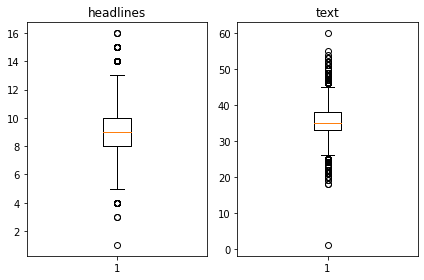

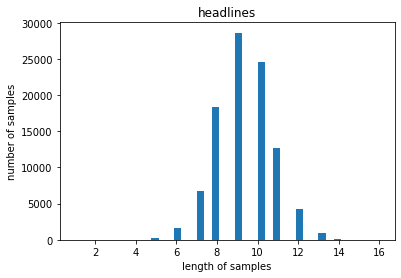

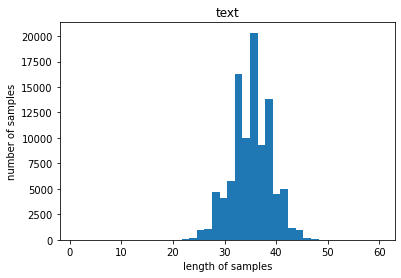

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 경우 최소 길이는 1 최대 길이는 60이며, 평균 35정도이다.  
Headlines의 경우 최소 길이는 1 최대 길이는 16이며, 평균 9 정도이다.  
둘다 그래프의 모양이 정규분포로 띈다.  
한 90%정돌 최대길이를 정하면 Text는 40, Headline은 11정도로 최대길이를 정해주었다.

In [17]:
text_max_len = 40
summary_max_len = 11

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


#### 2.4.2 시작 토큰과 종료 토큰 추가하기

In [21]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[73939 10989 72558 ... 45648 23900 72613]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#### 2.4.3 데이터 셋 나누기

In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


### 2.5 인코딩

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64634
등장 빈도가 6번 이하인 희귀 단어의 수: 44091
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20543
단어 집합에서 희귀 단어의 비율: 68.21641860321193
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.786939193296668


In [29]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4056, 4457, 3914, 582, 2098, 2451, 6862, 14758, 1865, 231, 1124, 5141, 16987, 1941, 441, 1679, 4257, 592, 2477, 7747, 16156, 2007, 315, 2116, 7748, 1534, 250, 2428, 7747, 9204, 2116, 1548, 315, 5784, 637], [26, 47, 15, 1230, 992, 68, 1, 1048, 1483, 642, 408, 747, 424, 188, 2067, 1148, 992, 1048, 787, 481, 6, 38, 89, 3732, 51, 234, 3675, 4057, 8023, 992, 1, 3566, 3182, 9, 424, 5785], [67, 127, 63, 2085, 2740, 2803, 2, 1040, 3888, 12, 1759, 67, 8493, 7480, 406, 81, 67, 7480, 5786, 299, 12, 10090, 237, 20, 63, 1, 1079, 1452, 7480, 406, 2, 385, 7480, 1075, 18015, 3091, 16]]


In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28489
등장 빈도가 5번 이하인 희귀 단어의 수: 18762
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9727
단어 집합에서 희귀 단어의 비율: 65.8569974376075
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.171540992659748


In [33]:

tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2502, 2935, 3853, 792, 4, 582, 64], [1, 429, 3, 961, 97, 344, 2222, 933, 46, 988, 1830], [1, 42, 2992, 946, 3, 5383, 29, 884, 23, 8180], [1, 46, 35, 1062, 81, 4, 18, 562, 3154, 1300], [1, 21, 5384, 1962, 1142, 7, 1933, 5385, 3404, 16]]
target
decoder  [[2502, 2935, 3853, 792, 4, 582, 64, 2], [429, 3, 961, 97, 344, 2222, 933, 46, 988, 1830, 2], [42, 2992, 946, 3, 5383, 29, 884, 23, 8180, 2], [46, 35, 1062, 81, 4, 18, 562, 3154, 1300, 2], [21, 5384, 1962, 1142, 7, 1933, 5385, 3404, 16, 2]]


In [34]:
# 요약문의 길이가 1인 경우 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :',len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17167
테스트 레이블의 개수 : 17167


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 패딩

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len)
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len)
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len)
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len)
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len)
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len)

## 3. 모델 설계하기

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [39]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [40]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 4. 모델 훈련하기

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 186s 650ms/step - loss: 6.3483 - val_loss: 5.6000
Epoch 2/50
269/269 [==============================] - 176s 653ms/step - loss: 5.6506 - val_loss: 5.4846
Epoch 3/50
269/269 [==============================] - 177s 658ms/step - loss: 5.5084 - val_loss: 5.3638
Epoch 4/50
269/269 [==============================] - 177s 658ms/step - loss: 5.3592 - val_loss: 5.4499
Epoch 5/50
269/269 [==============================] - 177s 660ms/step - loss: 5.0996 - val_loss: 4.8929
Epoch 6/50
269/269 [==============================] - 178s 663ms/step - loss: 4.8407 - val_loss: 4.7035
Epoch 7/50
269/269 [==============================] - 179s 665ms/step - loss: 4.6025 - val_loss: 4.5986
Epoch 8/50
269/269 [==============================] - 177s 658ms/step - loss: 4.4115 - val_loss: 4.4215
Epoch 9/50
269/269 [==============================] - 176s 656ms/step - loss: 4.2221 - val_loss: 4.3073
Epoch 10/50
269/269 [==============================] - 175s 652m

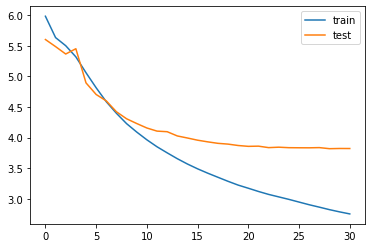

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

train 그래프만 보면 아주 적절하게 학습이 된것 같고, test와 train의 차이가 좀 나는 것을 보아 약간의 overfit된것 같다.

## 5. 인퍼런스 모델 구현하기

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [46]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 6. 모델 테스트 하기

In [47]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [48]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : london based british museum recently tweeted asian names confusing careful using many responding question making information accessible wider range people session keeper asia jane portal museum apologised criticised twitter users 
실제 요약 : sometimes asian names can be british museum 
예측 요약 :  asian american athlete named in us for st time since


원문 : joint team rajasthan ats chennai police tuesday detained suspected isis operator bazaar locality chennai tamil nadu year old suspected collecting sending funds recruiting youth terror group ats scanning detained man bank accounts check money flow terror links 
실제 요약 : rajasthan ats detains suspected isis operator from chennai 
예측 요약 :  police find policemen in kashmir to steal lakh in kashmir


원문 : demise gd agrawal another activist sant rushed hospital th day fast conservation river ganga suffering dehydration sugar level hospital reportedly permitted take measures necessary save life including force feeding 
실제 요약 : yr old hospital

## 7. 추출적 요약 해보기

In [88]:
for i, text in enumerate(data['text']):
    a = text.split()
    for j in range(1,len(a)) :
        if(j%7==0):
            a[j]+="."
    data['text'][i]=" ".join(a)


In [89]:
data['text'][1]

'kunal shah credit card bill payment platform cred. gave users chance win free food swiggy. one year pranav kaushik delhi techie bagged. reward spending cred coins users get one. cred coin per rupee bill paid used. avail rewards brands like ixigo bookmyshow ubereats. cult fit'

In [90]:
import requests
from summa.summarizer import summarize

In [91]:
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [92]:
# 실제 요약과 추출된 요약 비교
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : saurav kant alumnus upgrad iiit pg program machine. learning artificial intelligence sr systems engineer infosys. almost years work experience program upgrad degree. career support helped transition data scientist tech. mahindra salary hike upgrad online power learning. powered lakh careers
실제 요약 : upgrad learner switches to career in ml al with salary hike
추출 요약 : saurav kant alumnus upgrad iiit pg program machine.
almost years work experience program upgrad degree.
mahindra salary hike upgrad online power learning.


원문 : kunal shah credit card bill payment platform cred. gave users chance win free food swiggy. one year pranav kaushik delhi techie bagged. reward spending cred coins users get one. cred coin per rupee bill paid used. avail rewards brands like ixigo bookmyshow ubereats. cult fit
실제 요약 : delhi techie wins free food from swiggy for one year on cred
추출 요약 : kunal shah credit card bill payment platform cred.
reward spending cred coins users get one.
cred coin per rupee

## 회고
- 추출적 요약은 문장 단위로 끊어서 중요도를 계산하는 기법이라 문장부호가 정제된 문단을 전부 한 문장으로 인식하여서 처음에는 전부 빈칸으로 나왔다. 그래서 임의로 7단어마다 .을 추가하여 문장이 완료된 것처럼 만들고 넣어주니 결과가 나오긴 하였다.
- 임의로 7단어마다 . 추가하는 부분이 급하게 짠거라 별로 효율적이지 않은 것 같다. 양이 많은데 2중 for 문을 돌려서 오래걸렸다. 뭔가 좋은 방법이 있을 것같은데ㅜㅜ
- 추출적 요약은 문장그대로 들고 왔기 때문에 문법완성도가 높아야하지만 내가 임의로 문장을 잘라줘서 좀 이상한 부분도 있다. 추상적요약은 문법완성도는 꽤 괜찮은 것 같지만 내용을 비교해보면 말도안되게 요약해 놓은 것도 있으며 같은 단어를 반복적으로 사용하는 양상이 있다.
